In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '7' # Replace digit with number of desired GPU
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

%load_ext autoreload

In [2]:
# Basic Library Importsk
import jax
import jax.numpy as jnp
from jax import random
from jax import vmap, jit, grad, value_and_grad

from flax import linen as nn
import optax

from typing import Any, Callable, Sequence, Union
import matplotlib.pyplot as plt
import pandas as pd

import torch
import ml_collections

import time
import copy

import sys
sys.path.append('..') # makes modules in parent repository available to import

In [3]:
%autoreload 2
from archs import arch_from_config, ActNet, identity
from HelmholtzModel import HelmholtzModel
from utils import SquareDataset

In [4]:
# set up Helmholtz problem
w = 16
_kappa = 1
true_fun = lambda x, y : jnp.sin(jnp.pi*w*x)*jnp.sin(jnp.pi*w*y)
pde_res_fn = lambda x,y : (_kappa - (jnp.pi**2) * (w**2 + w**2))*true_fun(x,y) # residual of true fn
xx = jnp.linspace(-1,1, 128)
yy = jnp.linspace(-1,1, 128)
ins = jnp.meshgrid(xx, yy)
ins = [v.flatten()[:,None] for v in ins]
outs = true_fun(ins[0], ins[1])

In [5]:
# setup other training configurations
num_steps_adam = 30_000
num_steps_lbfgs = 100
seed = 0
batch_size = (5_000, 0)
normalize_inputs = True
pinn_weights = (0.001, 1.)
steps_per_check=500

In [6]:
# split keys
keys = random.split(random.key(seed))

# build data loader
data_loader = SquareDataset(keys[0], batch_size=batch_size)
batch = next(iter(data_loader))

## ActNet

In [7]:
arch = ActNet(embed_dim=196, num_layers=2, num_freqs=8,
              #freqs_init=nn.initializers.normal(stddev=.7),
              out_dim=1,
              freeze_basis=False,
              w0_fixed=jnp.pi*w,
              freq_scaling=True, freq_scaling_eps=1e-2,
              precision='highest')

# create optimizer
lr = optax.warmup_exponential_decay_schedule(
    1e-7, # init value
    5e-3, # peak value
    1_000, # wamup steps
    1_000, # transition_steps for decay
    0.75, # decay_rate
    end_value=1e-7, # stop decating once lr reaches this value
    )
optimizer = optax.chain(
    optax.adaptive_grad_clip(1e-2),
    optax.adam(learning_rate=lr),
    )

# create model
model = HelmholtzModel(
    arch, batch, optimizer=optimizer, key=keys[1], steps_per_check=steps_per_check,
    normalize_inputs=normalize_inputs, exact_bd_condition=True, bdr_enforcer_order=2,
    pde_res_fn = pde_res_fn, true_fun = true_fun, kappa=_kappa,
    pinn_weights=pinn_weights)
print(f"w is {w : .2f}")
print(model.tabulate())

w is  16.00

                                      ActNet Summary                                      
┏━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path       ┃ module   ┃ inputs            ┃ outputs           ┃ params                 ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│            │ ActNet   │ float32[5000,2]   │ float32[5000,1]   │                        │
├────────────┼──────────┼───────────────────┼───────────────────┼────────────────────────┤
│ Dense_0    │ Dense    │ float32[5000,2]   │ float32[5000,196] │ bias: float32[196]     │
│            │          │                   │                   │ kernel: float32[2,196] │
│            │          │                   │                   │                        │
│            │          │                   │                   │ 588 (2.4 KB)           │
├────────────┼──────────┼───────────────────┼───────────────────┼────────────

  0%|          | 0/30000 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:54<00:00,  1.83it/s, loss: 5.676e-03, rel_l2: 7.75e-04, 'grad_norm': 3.40e+01]


Final loss is  5.68e-03 and relative L2 error is  7.83e-04


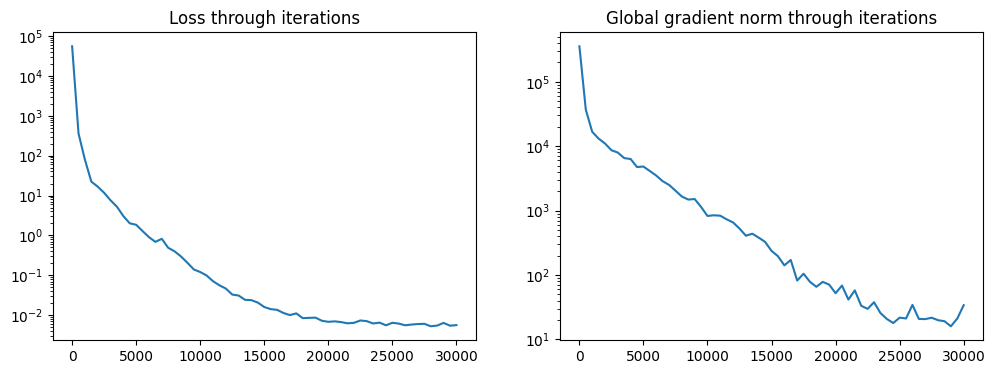

Relative L2 error: 7.83e-04
RMSE: 3.89e-04


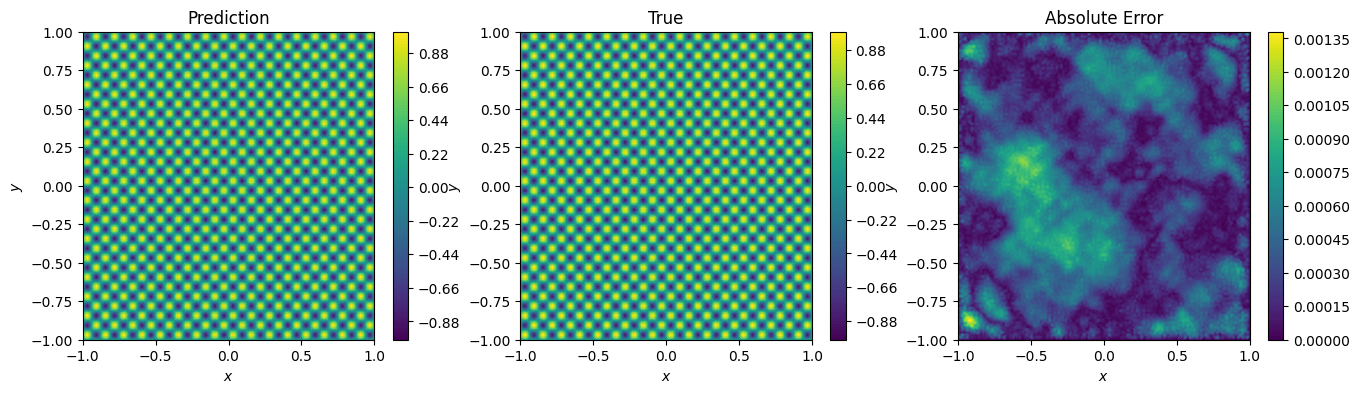

In [8]:
# train adam
model.train(data_loader, nIter=num_steps_adam)

# train lbfgs
model.train_lbfgs(data_loader, nIter=num_steps_lbfgs)

# save a copy of the ActNet model
actnet_model = copy.deepcopy(model)

# compute final relative l2 error on the grid
pred = model.apply(model.params, ins[0], ins[1])
rel_l2_error = jnp.sqrt(((pred-outs)**2).sum() / ((outs)**2).sum())

print(f'Final loss is {model.loss_log[-1] : .2e} and relative L2 error is {rel_l2_error : .2e}')
model.plot_logs()
model.plot_predictions((jnp.hstack(ins), outs))

## KAN

In [9]:
# setup other training configurations
num_steps_adam = 30_000
num_steps_lbfgs = 100
seed = 2
batch_size = (5_000, 0)
normalize_inputs = False
pinn_weights = (0.001, 1.)
steps_per_check=500

# split keys
keys = random.split(random.key(seed))

# build data loader
data_loader = SquareDataset(keys[0], batch_size=batch_size)
batch = next(iter(data_loader))

In [10]:
width = 48
depth = 1
grid_size = 30

# create config file for architecture
arch_config = ml_collections.ConfigDict()
arch_config.arch_type = 'KAN'
arch_config.num_layers = depth
arch_config.embed_dim = width
arch_config.hyperparams = {
    'features' : [2, width] + depth*[width] + [1],
    'output_activation' : identity,
    'grid_size' : grid_size,
    'spline_order': 3,
    'scale_noise' : 0.1,
    'scale_base' : 1.0,
    'scale_spline' : 1.0,
    'enable_standalone_scale_spline' : True,
    'base_activation' : nn.silu,
    'grid_eps' : 0.02,
    'grid_range' : (-1,1),
    'precision' : 'highest',
    }

In [11]:
arch = arch_from_config(arch_config)

# create optimizer
lr = optax.warmup_exponential_decay_schedule(
    1e-7, # init value
    5e-3, # peak value
    1_000, # wamup steps
    1_000, # transition_steps for decay
    0.75, # decay_rate
    end_value=1e-7, # stop decating once lr reaches this value
    )
optimizer = optax.chain(
    optax.adaptive_grad_clip(1e-2),
    optax.adam(learning_rate=lr),
    )

# create model
model = HelmholtzModel(
    arch, batch, optimizer=optimizer, key=keys[1], steps_per_check=steps_per_check,
    normalize_inputs=normalize_inputs, exact_bd_condition=True, bdr_enforcer_order=2,
    pde_res_fn = pde_res_fn, true_fun = true_fun, kappa=_kappa,
    pinn_weights=pinn_weights)
print(f"w is {w : .2f}")
print(model.tabulate())

w is  16.00

                                           KAN Summary                                           
┏━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path     ┃ module    ┃ inputs           ┃ outputs          ┃ params                           ┃
┡━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          │ KAN       │ float32[5000,2]  │ float32[5000,1]  │                                  │
├──────────┼───────────┼──────────────────┼──────────────────┼──────────────────────────────────┤
│ layers_0 │ KANLinear │ float32[5000,2]  │ float32[5000,48] │ base_weight: float32[48,2]       │
│          │           │                  │                  │ spline_scaler: float32[48,2]     │
│          │           │                  │                  │ spline_weight: float32[48,2,33]  │
│          │           │                  │                  │                                  │
│      

  0%|          | 0/30000 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:23<00:00,  1.20it/s, loss: 2.457e+00, rel_l2: 2.65e-01, 'grad_norm': 9.63e+01]


Final loss is  2.46e+00 and relative L2 error is  2.64e-01


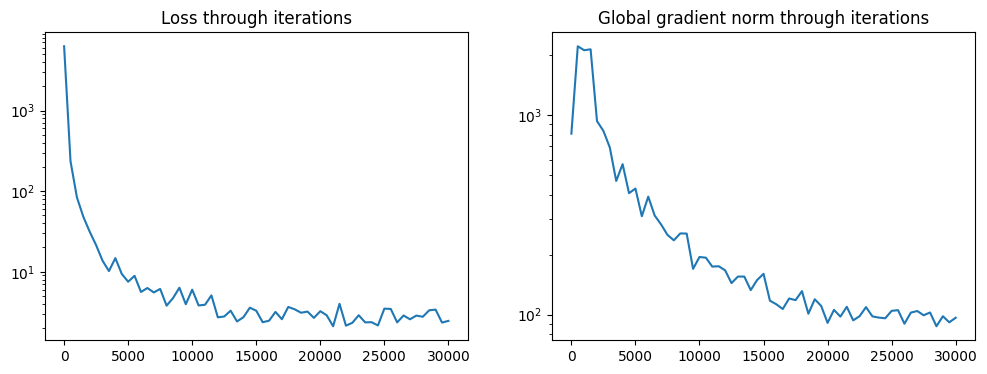

Relative L2 error: 2.64e-01
RMSE: 1.31e-01


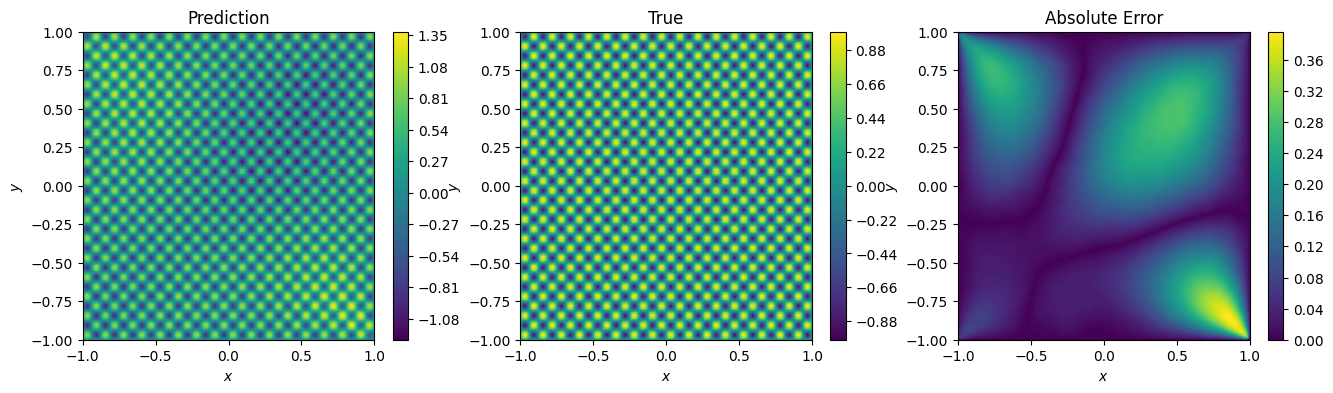

In [12]:
# train adam
model.train(data_loader, nIter=num_steps_adam)

# train lbfgs
model.train_lbfgs(data_loader, nIter=num_steps_lbfgs)

# save a copy of the KAN model
kan_model = copy.deepcopy(model)

# compute final relative l2 error on the grid
pred = model.apply(model.params, ins[0], ins[1])
rel_l2_error = jnp.sqrt(((pred-outs)**2).sum() / ((outs)**2).sum())

print(f'Final loss is {model.loss_log[-1] : .2e} and relative L2 error is {rel_l2_error : .2e}')
model.plot_logs()
model.plot_predictions((jnp.hstack(ins), outs))

## Siren

In [13]:
# setup other training configurations
num_steps_adam = 30_000
num_steps_lbfgs = 100
seed = 2
batch_size = (5_000, 0)
normalize_inputs = True
pinn_weights = (0.001, 1.)
steps_per_check=500

# split keys
keys = random.split(random.key(seed))

# build data loader
data_loader = SquareDataset(keys[0], batch_size=batch_size)
batch = next(iter(data_loader))

In [14]:
width = 141
depth = 4
w0_factor = 3

# create config file for architecture
arch_config = ml_collections.ConfigDict()
arch_config.arch_type = 'Siren'
arch_config.num_layers = depth
arch_config.embed_dim = width
arch_config.hyperparams = {
    'features' : [width] + depth*[width] + [1],
    'output_activation' :  identity,
    'w0' : jnp.pi*w*w0_factor,
    'precision' : 'highest',
    }

In [15]:
arch = arch_from_config(arch_config)

# create optimizer
lr = optax.warmup_exponential_decay_schedule(
    1e-7, # init value
    5e-3, # peak value
    1_000, # wamup steps
    1_000, # transition_steps for decay
    0.75, # decay_rate
    end_value=1e-7, # stop decating once lr reaches this value
    )
optimizer = optax.chain(
    optax.adaptive_grad_clip(1e-2),
    optax.adam(learning_rate=lr),
    )

# create model
model = HelmholtzModel(
    arch, batch, optimizer=optimizer, key=keys[1], steps_per_check=steps_per_check,
    normalize_inputs=normalize_inputs, exact_bd_condition=True, bdr_enforcer_order=2,
    pde_res_fn = pde_res_fn, true_fun = true_fun, kappa=_kappa,
    pinn_weights=pinn_weights)
print(f"w is {w : .2f}")
print(model.tabulate())

w is  16.00

                                     Siren Summary                                     
┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module ┃ inputs            ┃ outputs           ┃ params                   ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ Siren  │ float32[5000,2]   │ float32[5000,1]   │                          │
├─────────┼────────┼───────────────────┼───────────────────┼──────────────────────────┤
│ Dense_0 │ Dense  │ float32[5000,2]   │ float32[5000,141] │ bias: float32[141]       │
│         │        │                   │                   │ kernel: float32[2,141]   │
│         │        │                   │                   │                          │
│         │        │                   │                   │ 423 (1.7 KB)             │
├─────────┼────────┼───────────────────┼───────────────────┼──────────────────────────┤
│ Dense_1 │ Dense  

  0%|          | 0/30000 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:14<00:00,  6.70it/s, loss: 7.288e+00, rel_l2: 9.01e-02, 'grad_norm': 1.75e+03]


Final loss is  7.29e+00 and relative L2 error is  8.82e-02


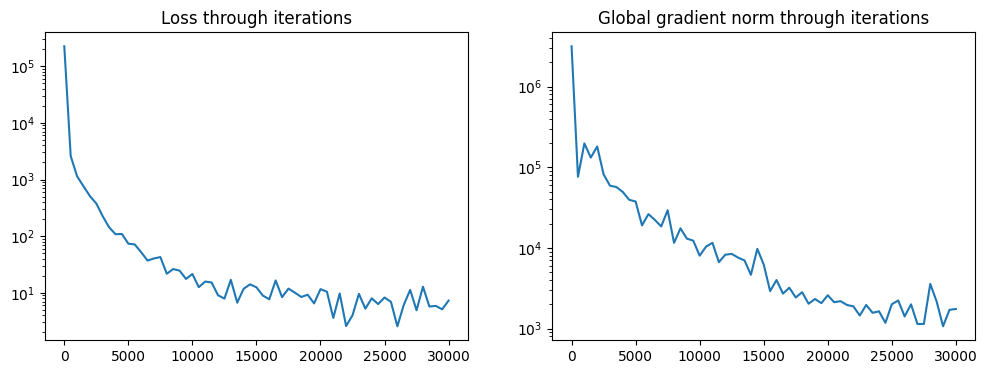

Relative L2 error: 8.82e-02
RMSE: 4.38e-02


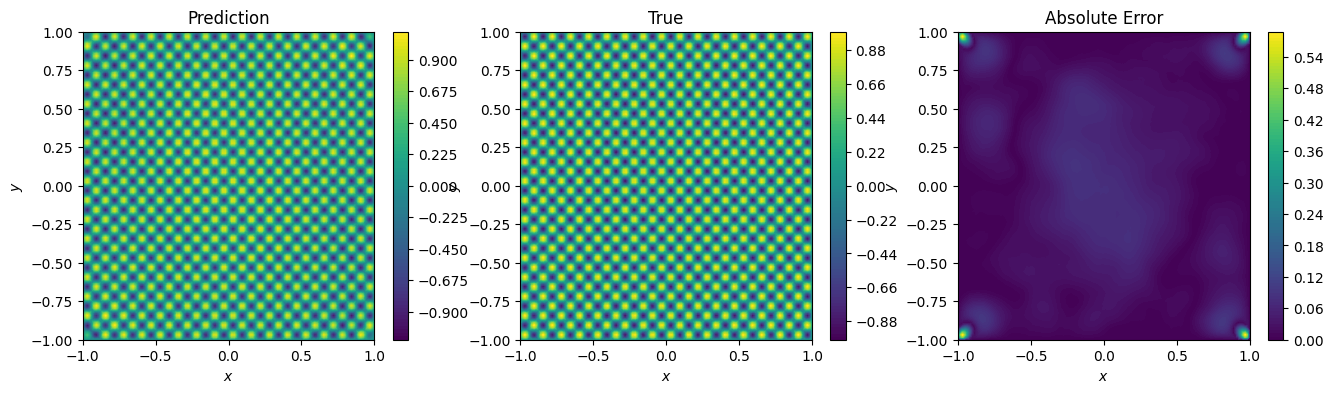

In [16]:
# train adam
model.train(data_loader, nIter=num_steps_adam)

# train lbfgs
model.train_lbfgs(data_loader, nIter=num_steps_lbfgs)

# save a copy of the Siren model
siren_model = copy.deepcopy(model)

# compute final relative l2 error on the grid
pred = model.apply(model.params, ins[0], ins[1])
rel_l2_error = jnp.sqrt(((pred-outs)**2).sum() / ((outs)**2).sum())

print(f'Final loss is {model.loss_log[-1] : .2e} and relative L2 error is {rel_l2_error : .2e}')
model.plot_logs()
model.plot_predictions((jnp.hstack(ins), outs))

## Plotting all three models

In [17]:
# higher resolution grid for plotting
# also slightly remove corners to better visualize residuals in the interior of the domain
xx = jnp.linspace(-.95,.95, 256)
yy = jnp.linspace(-.95,.95, 256)
ins = jnp.meshgrid(xx, yy)
ins = [v.flatten()[:,None] for v in ins]
outs = true_fun(ins[0], ins[1])

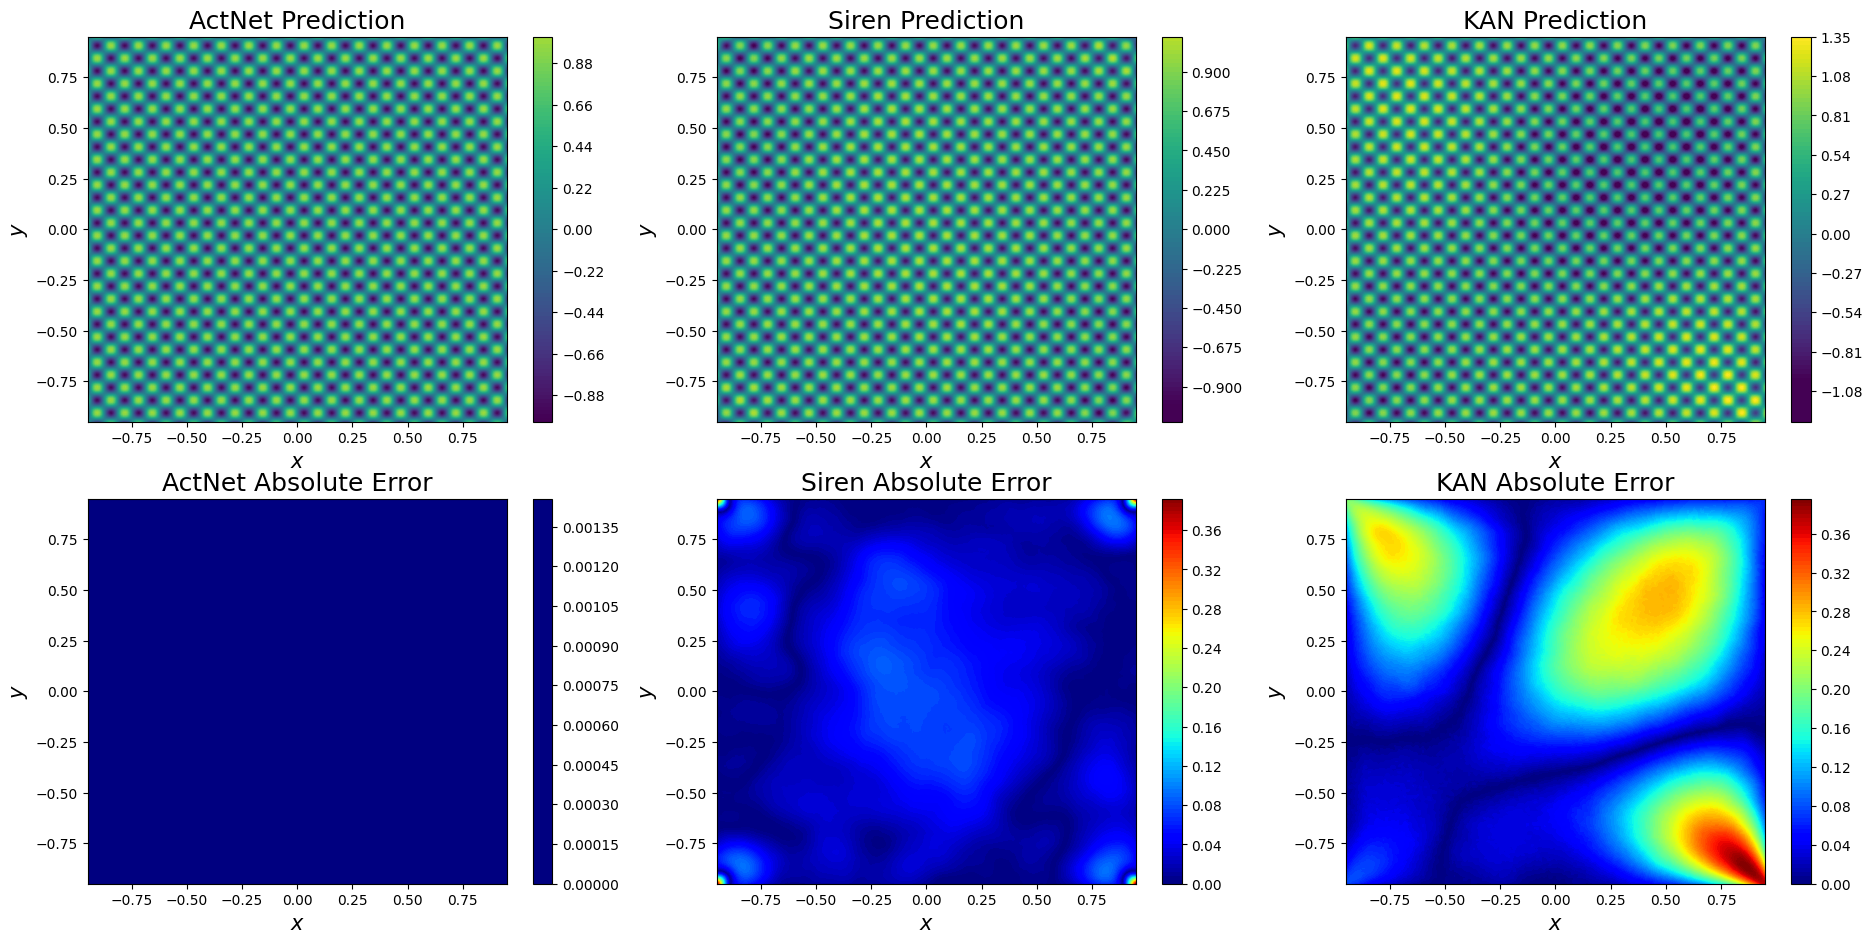

In [18]:
plt.figure(figsize=(23, 11))
u, s_true = jnp.hstack(ins), outs
title_size=18
axis_size=15

# Create predictions for actnet
s_pred_actnet = actnet_model.batched_apply(u, batch_size=2_048)
error_actnet = abs(s_pred_actnet - s_true)
# Create predictions for Siren
s_pred_siren = siren_model.batched_apply(u, batch_size=2_048)
error_siren = abs(s_pred_siren - s_true)
# Create predictions for KAN
s_pred_kan = kan_model.batched_apply(u, batch_size=2_048)
error_kan = abs(s_pred_kan - s_true)

vmax_pred = max(s_pred_actnet.max(), s_pred_siren.max(), s_pred_kan.max())
vmin_pred = max(s_pred_actnet.min(), s_pred_siren.min(), s_pred_kan.min())
vmax = max(error_actnet.max(), error_siren.max(), error_kan.max())

### ActNet
# Ploting examples of reconstructions
plt.subplot(231)
plt.tricontourf(u[:,0], u[:,1], s_pred_actnet.squeeze(), levels=100, vmax=vmax_pred, vmin=vmin_pred)
plt.colorbar()
plt.xlabel('$x$', fontsize=axis_size)
plt.ylabel('$y$', fontsize=axis_size)
plt.title('ActNet Prediction', fontsize=title_size)
# Ploting absolute error
plt.subplot(234)
plt.tricontourf(u[:,0], u[:,1], error_actnet.squeeze(), levels=100, vmax=vmax, cmap='jet')
plt.colorbar()
plt.xlabel('$x$', fontsize=axis_size)
plt.ylabel('$y$', fontsize=axis_size)
plt.title('ActNet Absolute Error', fontsize=title_size)

### Siren
# Ploting examples of reconstructions
plt.subplot(232)
plt.tricontourf(u[:,0], u[:,1], s_pred_siren.squeeze(), levels=100, vmax=vmax_pred, vmin=vmin_pred)
plt.colorbar()
plt.xlabel('$x$', fontsize=axis_size)
plt.ylabel('$y$', fontsize=axis_size)
plt.title('Siren Prediction', fontsize=title_size)
# Ploting absolute error
plt.subplot(235)
plt.tricontourf(u[:,0], u[:,1], error_siren.squeeze(), levels=100, vmax=vmax, cmap='jet')
plt.colorbar()
plt.xlabel('$x$', fontsize=axis_size)
plt.ylabel('$y$', fontsize=axis_size)
plt.title('Siren Absolute Error', fontsize=title_size)

### KAN
# Ploting examples of reconstructions
plt.subplot(233)
plt.tricontourf(u[:,0], u[:,1], s_pred_kan.squeeze(), levels=100, vmax=vmax_pred, vmin=vmin_pred)
plt.colorbar()
plt.xlabel('$x$', fontsize=axis_size)
plt.ylabel('$y$', fontsize=axis_size)
plt.title('KAN Prediction', fontsize=title_size)
# Ploting absolute error
plt.subplot(236)
plt.tricontourf(u[:,0], u[:,1], error_kan.squeeze(), levels=100, vmax=vmax, cmap='jet')
plt.colorbar()
plt.xlabel('$x$', fontsize=axis_size)
plt.ylabel('$y$', fontsize=axis_size)
plt.title('KAN Absolute Error', fontsize=title_size)


plt.savefig('Helmholtz16_all_predictions_horizontal.png', bbox_inches='tight', dpi=300)

plt.show()